# Training and Testing an MDRNN on Synthetic Data

This script trains and tests a mixture density recurrent neural network (MDRNN) on synthetic performances.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import sketch_mdn

## Generating Fake data:

The idea is to generate some data that "could" have been human, but has a regular pattern. The time axis is sampled from a normal distribution with the same mean and S.D. as the human corpus. The value axis is generated by applying regular signal functions (e.g., sine, square, triangle) to this time axis.


                 dt       seconds         value
count  15000.000000  15000.000000  1.500000e+04
mean       0.150718   1130.446992  5.016202e-01
std        0.114045    653.564740  3.544727e-01
min        0.000005      0.319669  9.832351e-09
25%        0.060070    562.749729  1.453696e-01
50%        0.127148   1134.910901  5.066051e-01
75%        0.217463   1692.385506  8.564308e-01
max        0.731234   2260.771530  1.000000e+00


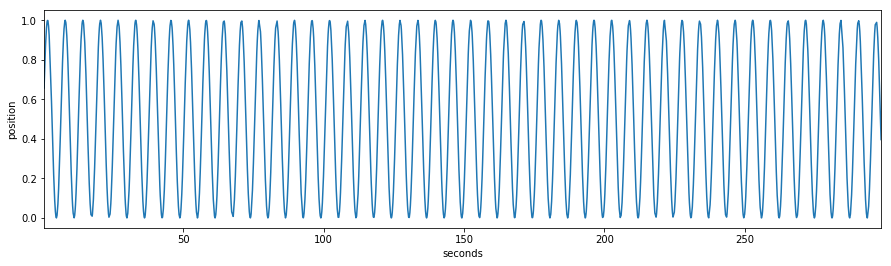

In [3]:
# Generate fake Sine movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

sine_df = pd.DataFrame({'dt' : t_diffs})
sine_df.dt = sine_df.dt.abs()
sine_df['seconds'] = sine_df.dt.cumsum()
sine_df['value'] = (np.sin(sine_df.seconds) * 0.5) + 0.5
print(sine_df.describe())

ax = sine_df[:2000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('sine_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('sine_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': sine_df.dt, 'x': sine_df.value})
sine_corpus = np.array(corpus_df)

                 dt       seconds         value
count  15000.000000  15000.000000  15000.000000
mean       0.152996   1143.433666      0.497067
std        0.115071    662.583373      0.500008
min        0.000029      0.452236      0.000000
25%        0.062417    565.531525      0.000000
50%        0.129629   1145.222071      0.000000
75%        0.220325   1717.205832      1.000000
max        0.764845   2294.937487      1.000000


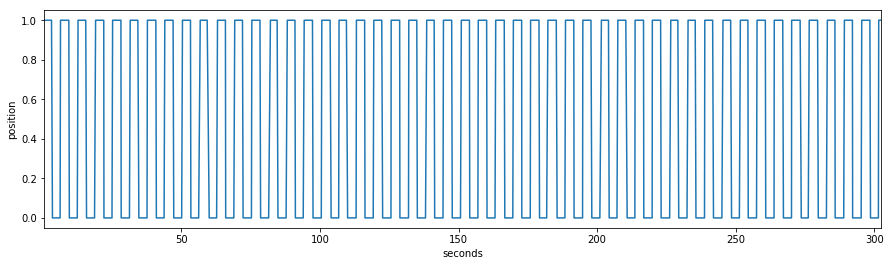

In [5]:
# Generate fake Squarey Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

square_df = pd.DataFrame({'dt' : t_diffs})
square_df.dt = square_df.dt.abs()
square_df['seconds'] = square_df.dt.cumsum()
square_df['value'] = (scipy.signal.square(square_df.seconds) * 0.5) + 0.5
print(square_df.describe())

ax = square_df[:2000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('square_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('square_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': square_df.dt, 'x': square_df.value})
square_corpus = np.array(corpus_df)

                 dt       seconds         value
count  15000.000000  15000.000000  15000.000000
mean       0.149351   1122.337137      0.499943
std        0.111753    647.363023      0.288673
min        0.000009      0.191704      0.000006
25%        0.060503    560.212573      0.251758
50%        0.126479   1127.207313      0.499740
75%        0.214893   1682.118464      0.749381
max        0.918576   2240.272086      0.999936


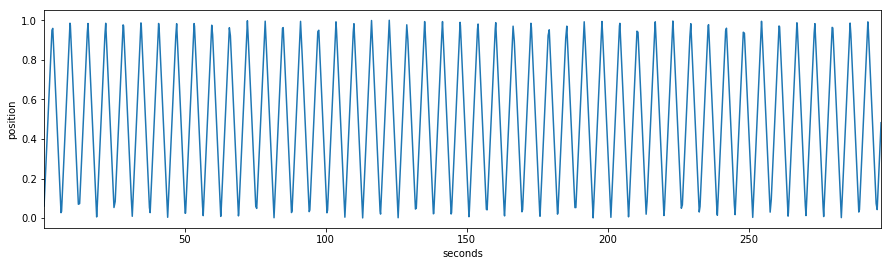

In [9]:
# Generate fake triangle-y Movement

time_mean = 0.044860
time_std = 0.183995
time_min = 0.000454
time_max = 8.463944
NSAMPLE = 15000

t_diffs = np.random.normal(loc=time_mean, scale=time_std, size=NSAMPLE)

tri_df = pd.DataFrame({'dt' : t_diffs})
tri_df.dt = tri_df.dt.abs()
tri_df['seconds'] = tri_df.dt.cumsum()
tri_df['value'] = (scipy.signal.sawtooth(tri_df.seconds, width=0.5) * 0.5) + 0.5
print(tri_df.describe())

ax = tri_df[:2000].plot(x='seconds', y='value', kind="line", figsize=(15,4), legend=False)
ax.set_xlabel("seconds")
ax.set_ylabel("position")
ax.get_figure().savefig('tri_data_output.pdf', dpi=300, bbox_inches="tight")
ax.get_figure().savefig('tri_data_output.png', dpi=300, bbox_inches="tight")

corpus_df = pd.DataFrame({'t': tri_df.dt, 'x': tri_df.value})
tri_corpus = np.array(corpus_df)

In [ ]:
# Train networks with the Synthetic data

Training an MDN with these synthetic data sets.

### Here are the corpora

- square_corpus
- tri_corpus
- sine_corpus

In [10]:
# Hyperparameters
units = 128
mixes = 8
layers = 3
batch_s = 100
n_steps = 120
epochs = 10

# Train
net = sketch_mdn.MixtureRNN(mode = sketch_mdn.NET_MODE_TRAIN, 
                            n_hidden_units=units, 
                            n_mixtures=mixes, 
                            batch_size=batch_s, 
                            sequence_length=n_steps, 
                            layers=layers)
loader = sketch_mdn.SequenceDataLoader(num_steps=(n_steps + 1), batch_size=batch_s, corpus=tri_corpus)
losses = net.train(loader, epochs, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()

INFO:tensorflow:Loading Training Operations
INFO:tensorflow:done initialising: mixture-rnn-3layers-128units vars: 336432
Total training examples: 14878
Done initialising loader.
INFO:tensorflow:going to train: mixture-rnn-3layers-128units


KeyboardInterrupt: 